Тема: Основы статистики и статистические критерии

Видео лекции:  
https://www.youtube.com/watch?v=v4ydaa-94nI
    
Видео семинара:  
https://www.youtube.com/watch?v=VKuY4ApfH6M

# Повторяю семинар

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import time
import seaborn as sns

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

# plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
# plt.rcParams['legend.handletextpad'] = 0.5
# plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
# plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
# plt.rcParams['font.size'] = 12
# plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

In [3]:
# Распределение Стьюдента

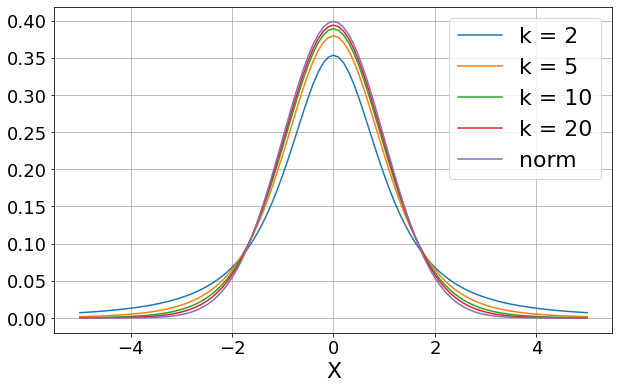

In [4]:
X = np.linspace(-5, 5, 101)
k_list = [2, 5, 10, 20]
for k in k_list:
    t_y = stats.t.pdf(X, k)
    plt.plot(X, t_y, label=f"{k = }")
plt.plot(X, stats.norm.pdf(X, 0, 1), label='norm')
plt.legend()
plt.xlabel('X')
plt.grid()

In [5]:
def get_student_parameter(data1: np.array, data2: np.array) -> float:
    """
    Расчет параметра Стьюдента - кол-во степеней свободы
    """
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    std1 = np.std(data1)
    std2 = np.std(data2)
    
    k = (std1 ** 2 / n1 + std2 ** 2 / n2) ** 2 / \
        (std1 ** 4 / (n1 ** 2 * (n1 - 1)) + std2 ** 4 / (n2 ** 2 * (n2 - 1)))

    return k

In [6]:
def get_ttest_statistics(data1: np.array, data2: np.array) -> float:
    """
    Расчет t-статстики
    """
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    std1 = np.std(data1, ddof=1)
    std2 = np.std(data2, ddof=1)
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    
    t = (mean1 - mean2) / (std1 ** 2 / n1 + std2 ** 2 / n2) ** 0.5
    
    return t
    

In [7]:
# данные для примера
np.random.seed(44)
sample_size = 100
data_control = np.random.normal(1, 1, sample_size)
data_pilot = np.random.normal(1.2, 1, sample_size)

k = get_student_parameter(data_control, data_pilot)
print(f"student_parameter = {k}")

alpha = 0.05
critical_region_bounds = stats.t.ppf([alpha / 2, 1 - alpha / 2], df=k)
print(f"{critical_region_bounds = }")

t_stat = get_ttest_statistics(data_control, data_pilot)
print(f"{t_stat = }")

pval = stats.t.cdf(t_stat, df=k) * 2
print(f"{pval = }")

real1 = stats.ttest_ind(data_control, data_pilot)
real2 = stats.ttest_ind(data_control, data_pilot, equal_var=False)
print(real1, real2)

student_parameter = 196.53643393447297
critical_region_bounds = array([-1.97210778,  1.97210778])
t_stat = -1.8203056424009751
pval = 0.0702335577441075
Ttest_indResult(statistic=-1.8203056424009751, pvalue=0.07022230781028711) Ttest_indResult(statistic=-1.8203056424009751, pvalue=0.0702335577441075)


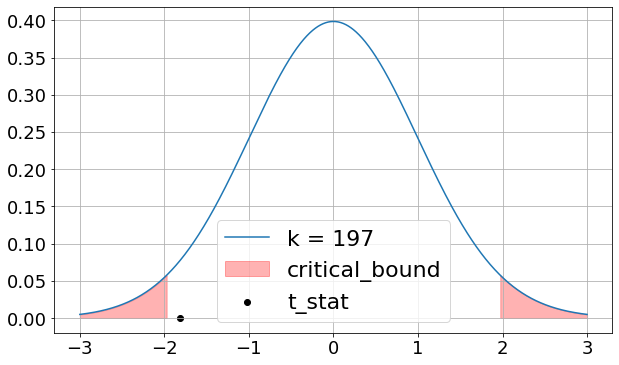

In [8]:
# визуализация
X = np.linspace(-3, 3, 1000)
Y = stats.t.pdf(X, df=k)

X_list_mask = [X < critical_region_bounds[0], X > critical_region_bounds[1]]
for idx, mask in enumerate(X_list_mask):
    X_ = X[mask]
    Y_up = Y[mask]
    Y_down = np.zeros(Y_up.shape[0])
    plt.fill_between(
        X_, Y_down, Y_up,
        color = 'r',
        alpha = 0.3,
        label = 'critical_bound' if idx == 0 else ''
    )
plt.scatter([t_stat], [0], label='t_stat', color='k')
plt.plot(X, Y, label=f"k = {k:0.0f}")
plt.legend()
plt.grid()

# Статистические тесты

In [9]:
def check_ttest(a: np.array, b: np.array, alpha: float = 0.05) -> int:
    """
     Проверка стат.значимости t-тестом. Возвращает 1, если различия значимы
    """
    _, pval = stats.ttest_ind(a, b)
    return int(pval < alpha)

def check_mann_whitneyu(a: np.array, b: np.array, alpha: float = 0.05) -> int:
    """
    Проверка стат.значимости тестом Манн-Уитни. Возвращает 1, если различия значимы
    """
    _, pval = stats.mannwhitneyu(a, b, alternative='two-sided')
    return int(pval < alpha)
                                 
def check_bootstrap(a: np.array, b: np.array, B: int = 1000, alpha: float = 0.05) -> int:
    """
    Проверка стат.значимости бутстрепом. Возвращает 1, если различия значимы
    """
    b1 = np.random.choice(a, size=[a.shape[0], B], replace=True)
    b2 = np.random.choice(b, size=[b.shape[0], B], replace=True)
    diffs = np.mean(b2, axis=0) - np.mean(b1, axis=0)
    left_bound = np.quantile(diffs, alpha / 2)
    right_bound = np.quantile(diffs, 1 - alpha / 2)
    result = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return result

dict_tests = {
    'ttest': check_ttest,
    'mannwhitneyu': check_mann_whitneyu,
    'bootstrap': check_bootstrap
}

In [10]:
results = dict()

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0, 1, 100)
    for test_name, test in dict_tests.items():
        results.setdefault(test_name, []).append(test(a, b))

print({test_name: np.mean(res) for test_name, res in results.items()})

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 304.00it/s]

{'ttest': 0.045, 'mannwhitneyu': 0.045, 'bootstrap': 0.051}


In [11]:
results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0.4, 1, 100)
    for test_name, test in dict_tests.items():
        results[test_name].append(test(a, b))

print({test_name: np.mean(res) for test_name, res in results.items()})

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 295.77it/s]

{'ttest': 0.824, 'mannwhitneyu': 0.793, 'bootstrap': 0.828}


## Скорость работы

In [12]:
test_time = dict()
sample_sizes = np.logspace(2, 5, 20).astype(int)

for sample_size in tqdm(sample_sizes):
    a = np.random.normal(0, 1, sample_size)
    b = np.random.normal(0, 1, sample_size)
    for test_name, test in dict_tests.items():
        t1 = time.time()
        test(a, b)
        t2 = time.time()
        test_time.setdefault(test_name, []).append(t2 - t1)
    

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  2.00it/s]


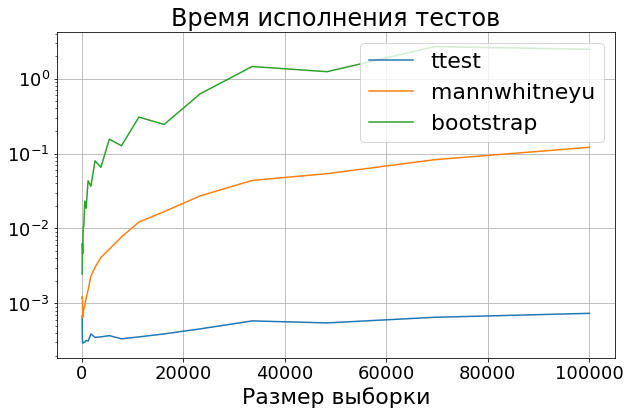

In [13]:
for test_name, times in test_time.items():
    plt.plot(sample_sizes, times, label=test_name)
plt.title('Время исполнения тестов')
plt.grid()
plt.xlabel('Размер выборки')
plt.legend()
plt.yscale('log')

In [14]:
# Т.к. бутстреп сильно медленнее, то исключаю его из дальнейших тестов
dict_tests = {test_name: dict_tests[test_name] for test_name in ['ttest', 'mannwhitneyu']}

In [15]:
dict_tests

{'ttest': <function __main__.check_ttest(a: <built-in function array>, b: <built-in function array>, alpha: float = 0.05) -> int>,
 'mannwhitneyu': <function __main__.check_mann_whitneyu(a: <built-in function array>, b: <built-in function array>, alpha: float = 0.05) -> int>}

In [16]:
# Вспомогательные функции
def aab_sample_generator(dist_a, dist_b):
    def _aab_samples(sample_size):
        a1 = dist_a.rvs(sample_size)
        a2 = dist_a.rvs(sample_size)
        b = dist_b.rvs(sample_size)
        return(a1, a2, b)
    return _aab_samples

def run_experiment(sample_sizes, generator, N=1000):
    type_1_errors = dict()
    type_2_errors = dict()
    for sample_size in sample_sizes:
        test_results_aa = dict()
        test_results_ab = dict()
        for _ in range(N):
            a1, a2, b = generator(sample_size)
            for test_name, test in dict_tests.items():
                test_results_aa.setdefault(test_name, []).append(test(a1, a2))
                test_results_ab.setdefault(test_name, []).append(test(a1, b))
    
        for test_name, test in dict_tests.items():
            type_1_errors.setdefault(test_name, []).append(np.mean(test_results_aa[test_name]))
            type_2_errors.setdefault(test_name, []).append(1 - np.mean(test_results_ab[test_name]))

    return type_1_errors, type_2_errors

def plot_errors(x, data_dict, xlabel='', title=''):
    for key, values in data_dict.items():
        plt.plot(x, values, label=key)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.show()

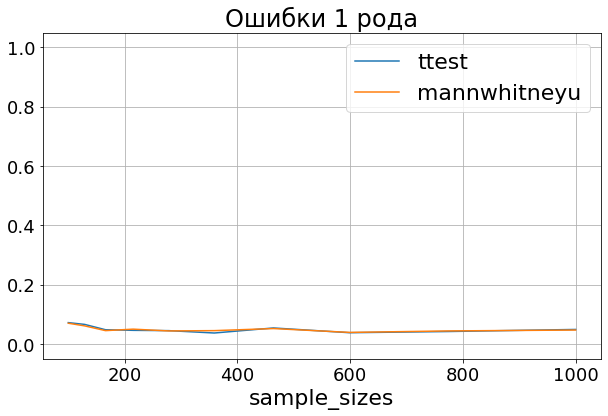

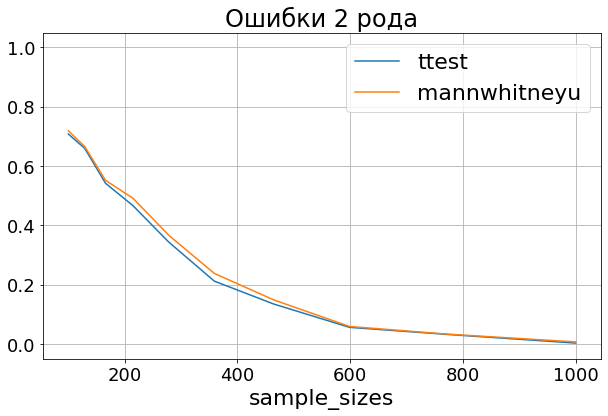

In [17]:
sample_sizes = np.logspace(2, 3, 10).astype(int)

dist_a = stats.norm(loc=0, scale=1)
dist_b = stats.norm(loc=0.2, scale=1)

generator = aab_sample_generator(dist_a, dist_b)

type_1_errors, type_2_errors = run_experiment(sample_sizes, generator)

plot_errors(sample_sizes, type_1_errors, 'sample_sizes', 'Ошибки 1 рода')
plot_errors(sample_sizes, type_2_errors, 'sample_sizes', 'Ошибки 2 рода')


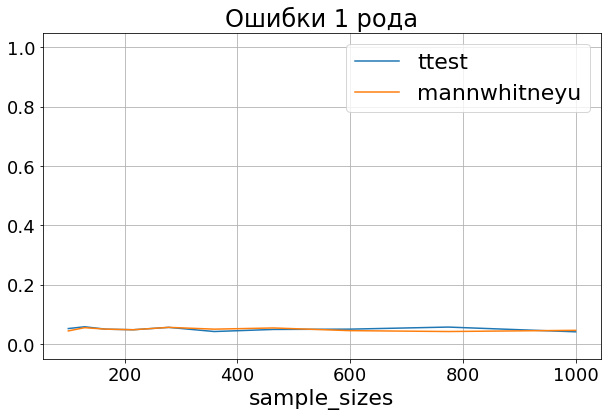

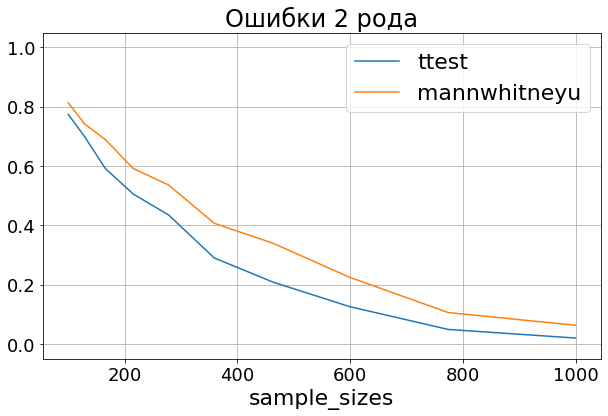

In [18]:
sample_sizes = np.logspace(2, 3, 10).astype(int)

dist_a = stats.expon(loc=0, scale=1)
dist_b = stats.expon(loc=0, scale=1.2)

generator = aab_sample_generator(dist_a, dist_b)

type_1_errors, type_2_errors = run_experiment(sample_sizes, generator)

plot_errors(sample_sizes, type_1_errors, 'sample_sizes', 'Ошибки 1 рода')
plot_errors(sample_sizes, type_2_errors, 'sample_sizes', 'Ошибки 2 рода')

## Чувствительность к выбросам

In [19]:
N = 1000
outliers = np.arange(-150, 300, 15)
test_type_1_errors = dict()
test_type_2_errors = dict()

sample_size = 500

for outlier in tqdm(outliers):
    res_type_1 = dict()
    res_type_2 = dict()
    for _ in range(N):
        a1 = np.random.normal(0, 1, sample_size)
        a1[0] = outlier
        a2 = np.random.normal(0, 1, sample_size)
        b = np.random.normal(0.2, 1, sample_size)
        
        for test_name, test in dict_tests.items():
            res_type_1.setdefault(test_name, []).append(test(a1, a2))
            res_type_2.setdefault(test_name, []).append(test(a1, b))
            
    for test_name, test in dict_tests.items():
        test_type_1_errors.setdefault(test_name, []).append(np.mean(res_type_1[test_name]))
        test_type_2_errors.setdefault(test_name, []).append(1 - np.mean(res_type_2[test_name]))

100%|███████████████████████████████████████████| 30/30 [01:02<00:00,  2.08s/it]


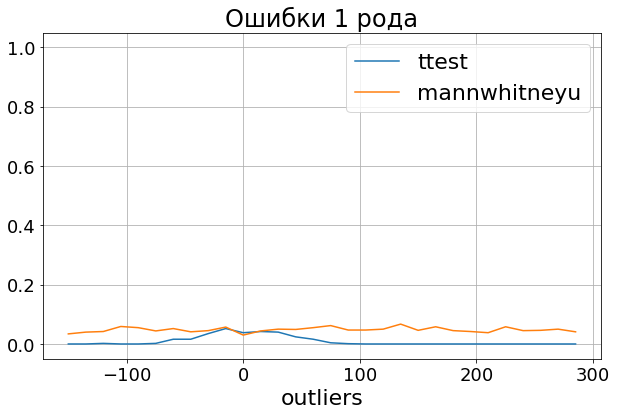

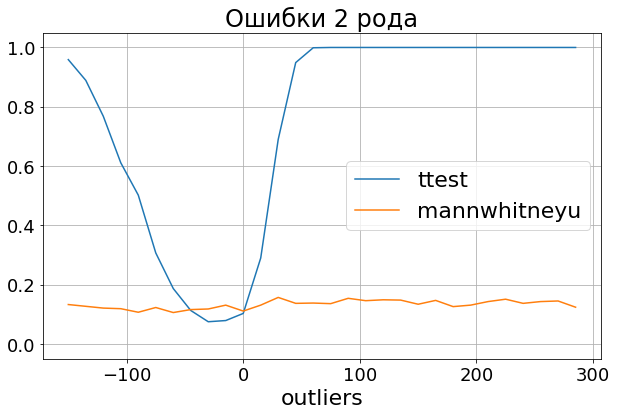

In [20]:
plot_errors(outliers, test_type_1_errors, 'outliers', 'Ошибки 1 рода')
plot_errors(outliers, test_type_2_errors, 'outliers', 'Ошибки 2 рода')

In [21]:
N = 1000
outliers = np.arange(-150, 300, 15)
test_type_1_errors = dict()
test_type_2_errors = dict()

sample_size = 500

for outlier in tqdm(outliers):
    res_type_1 = dict()
    res_type_2 = dict()
    for _ in range(N):
        a1 = np.random.normal(0, 1, sample_size)
        a1[:5] = outlier
        a2 = np.random.normal(0, 1, sample_size)
        b = np.random.normal(0.2, 1, sample_size)
        
        for test_name, test in dict_tests.items():
            res_type_1.setdefault(test_name, []).append(test(a1, a2))
            res_type_2.setdefault(test_name, []).append(test(a1, b))
            
    for test_name, test in dict_tests.items():
        test_type_1_errors.setdefault(test_name, []).append(np.mean(res_type_1[test_name]))
        test_type_2_errors.setdefault(test_name, []).append(1 - np.mean(res_type_2[test_name]))

100%|███████████████████████████████████████████| 30/30 [01:10<00:00,  2.36s/it]


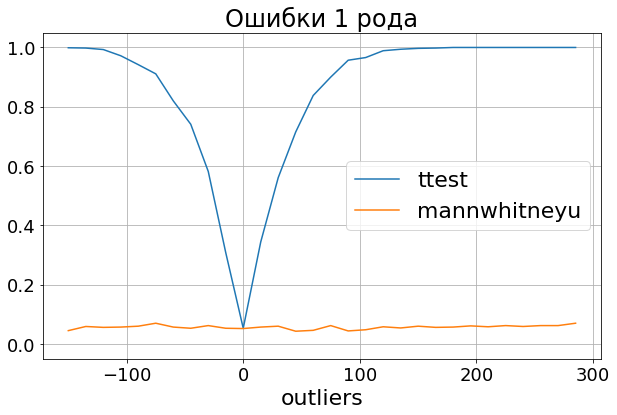

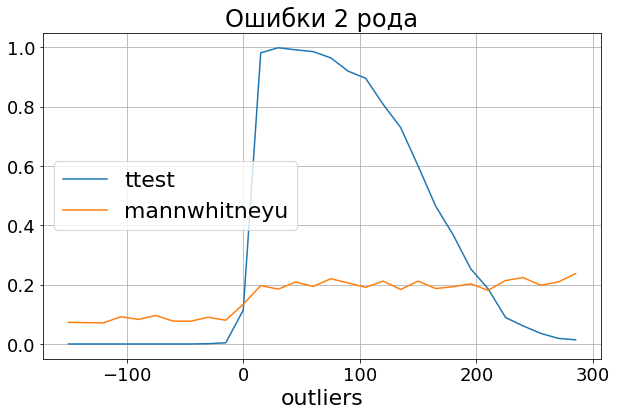

In [22]:
plot_errors(outliers, test_type_1_errors, 'outliers', 'Ошибки 1 рода')
plot_errors(outliers, test_type_2_errors, 'outliers', 'Ошибки 2 рода')

## Бутстрап

In [23]:
N = 100
dist = stats.expon(loc=0, scale=1)
X = dist.rvs(size=N, random_state=23)

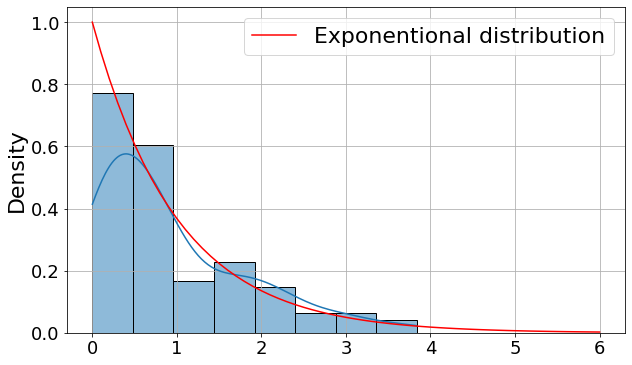

In [24]:
x = np.linspace(0, 6, 61)

pdf = dist.pdf(x)

sns.histplot(data=X, kde=True, stat='density')
plt.plot(x, pdf, label='Exponentional distribution', c='r')
plt.legend()
plt.grid()

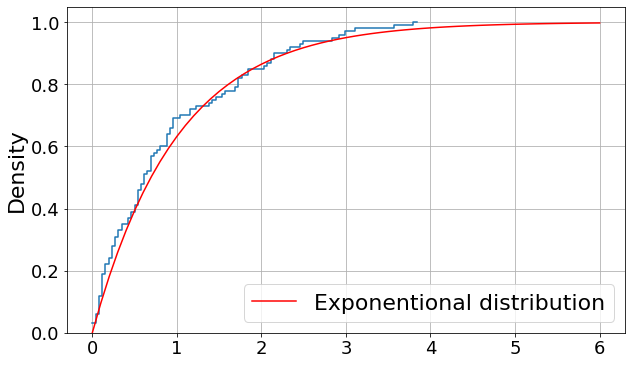

In [25]:
cdf = dist.cdf(x)
sns.histplot(data=X, cumulative=True, stat='density',
            fill=False, element='step', bins=100)
plt.plot(x, cdf, label='Exponentional distribution', c='r')
plt.legend()
plt.grid()

In [26]:
skewness_sample = stats.skew(X)
distribution_skiwness = dist.stats(moments='s')

skewness_sample, distribution_skiwness

(1.2274496724312205, array(2.))

In [27]:
print(f"fasdasd {distribution_skiwness}")

fasdasd 2.0


In [28]:
B = 10_000

sample_sizes = np.arange(20, 101, 5)
list_points = []
for size in tqdm(sample_sizes):
    sub_X = X[:size]
    bootstrap = np.random.choice(sub_X, size=[size, B], replace=True)
    bootstrap_skewness = stats.skew(bootstrap, axis=0)
    list_points.append(bootstrap_skewness)

aplpha = 0.05

np_points = np.array(list_points)
bounds = np.quantile(np_points, [alpha / 2, 1 - alpha / 2], axis=1)
means = np.mean(np_points, axis=1)

100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 68.64it/s]


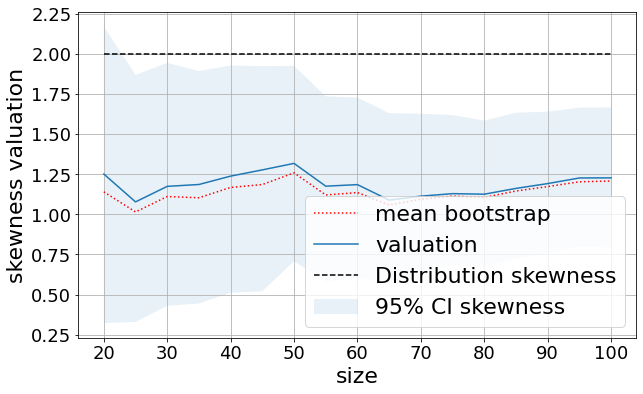

In [30]:
plt.fill_between(sample_sizes, bounds[0], bounds[1], alpha=0.1, label='95% CI skewness')
plt.plot(sample_sizes, means, ':r', label='mean bootstrap')
plt.plot(sample_sizes, [stats.skew(X[:size]) for size in sample_sizes], label='valuation')
plt.plot(sample_sizes, np.full(len(sample_sizes), distribution_skiwness), '--k', label='Distribution skewness')
plt.xlabel('size')
plt.ylabel('skewness valuation')
plt.legend()
plt.grid()
plt.show()

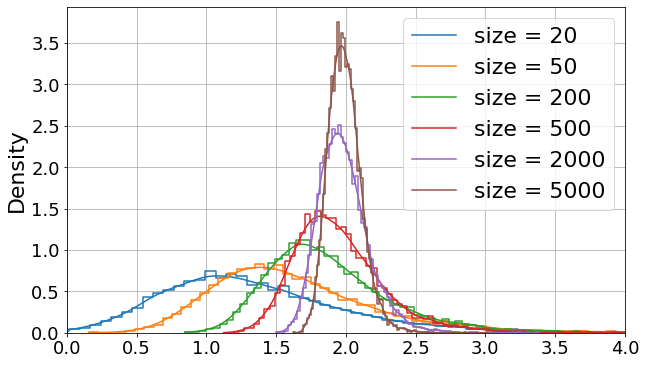

In [36]:
for sample_size in [20, 50, 200, 500, 2000, 5000]:
    points = dist.rvs(size=(sample_size, 10_000))
    skewness = stats.skew(points, axis=0)
    
    sns.histplot(skewness, kde=True, fill=False, element='step', stat='density', label=f"size = {sample_size}")
plt.xlim(0, 4)
plt.legend()
plt.grid()
plt.show()

In [37]:
X_new = dist.rvs(size=(1000, 10_000), random_state=23)

In [41]:
list_points = []
sample_sizes = np.logspace(1.5, 3, 20).astype(int)

for size in sample_sizes:
    sub_X = X_new[:size]
    skewness = stats.skew(sub_X, axis=0)
    list_points.append(skewness)
    
alpha = 0.5

np_points = np.array(list_points)
bounds = np.quantile(np_points, (alpha / 2, 1 - alpha / 2), axis=1)
means = np.mean(np_points, axis=1)

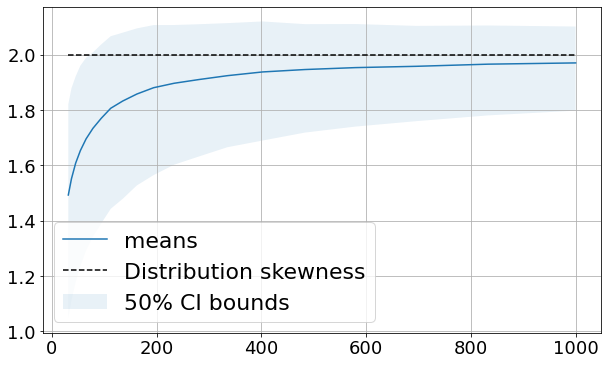

In [44]:
plt.fill_between(sample_sizes, bounds[0], bounds[1], alpha=0.1, label='50% CI bounds')
plt.plot(sample_sizes, means, label='means')
plt.plot(sample_sizes, np.full(len(sample_sizes), distribution_skiwness), '--k', label='Distribution skewness')
plt.legend()
plt.grid()
plt.show()

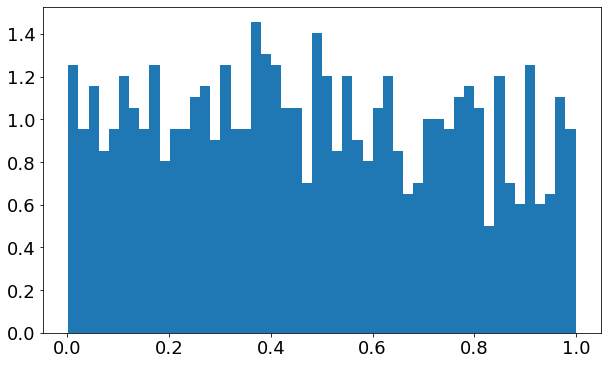

In [75]:
p_vals = []
for _ in range(1000):
    a = np.random.lognormal(10, 1, 100)
    b = np.random.lognormal(10, 1, 100)
    _, p_val = stats.ttest_ind(a, b)
    p_vals.append(p_val)
plt.hist(p_vals, cumulative=False, bins=50, density=True);
# plt.hist(p_vals, cumulative=True, density=True, bins=50);

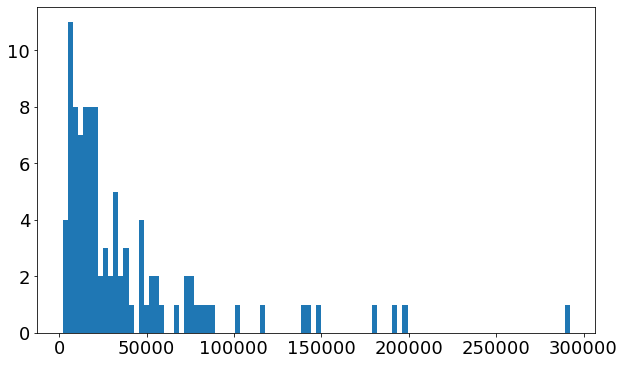

In [76]:
plt.hist(a, bins=100);

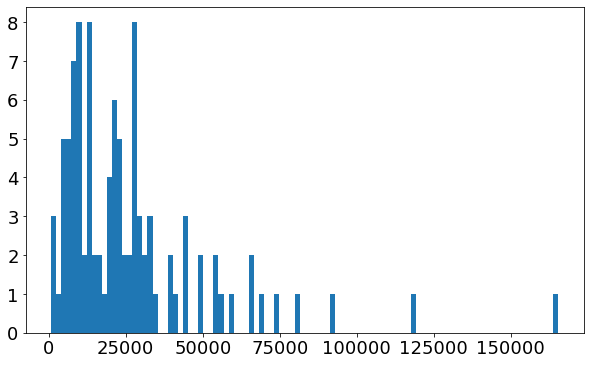

In [77]:
plt.hist(b, bins=100);